# Part 10. DEAP Dataset + CNN1D_LSTM + Self MultiHead Attention

In this part 10, we shall revise just slightly and add some multiheads attention, which is again inspired by the Transformers architecture.

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In this part, most of the code will be the same except 2 Defining Model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

import numpy as np

#refactoring components
#maybe you want to take a look at these components, because we will be using them in the future series
from components.dataset import Dataset
from components.helper import getLoaders, count_parameters, plot_performance
from components.train import train, evaluate, initialize_weights

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [3]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [4]:
dataset = Dataset(path, "Valence")

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  torch.Size([15360, 32, 672])
Label shape:  torch.Size([15360, 1])


## 2. Defining the Model

Self Attention is a very simple idea in which we wanna find the best weighted sum of all hidden states, instead of using the last hidden state to input into the linear layer.  However, the procedure in doing so it's a bit different, especially in step 1.  In order to find that weight, we 
1. we create three copies of (i.e., <code>out</code>) and called them Q (queries), K (key), V (value)
2. attention weights matrix is done by having Q and K dotted together
3. perform a softmax on this attention matrix so we can get value between 0 and 1
4. lastly, we simply multiply this attention matrix with V

In [5]:
class Conv1D_LSTM_SelfMultiHeadAttention(nn.Module):
    '''
    Expected Input Shape: (batch, channels, seq_len)  <==what conv1d wants
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout, len_reduction='mean'):
        super(Conv1D_LSTM_SelfMultiHeadAttention, self).__init__()
        self.conv1d = nn.Conv1d(input_dim, input_dim, kernel_size=128, stride=1, padding=1)
        self.norm = nn.BatchNorm1d(input_dim)
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.softmax       = nn.LogSoftmax(dim=1)
        self.fc = nn.Linear(hidden_dim * num_layers, output_dim)
        self.lin_Q = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_K = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_V = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.len_reduction = len_reduction
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
    
    # lstm_output : [batch_size, seq len, n_hidden * num_directions(=2)]
    def self_multihead_attention_net(self, lstm_output):
        
        residual, batch_size = lstm_output, lstm_output.size(0) #<---residual added to the last output; batch_size may not be even for the last unit
        
        q = self.lin_Q(torch.clone(lstm_output))
        k = self.lin_K(torch.clone(lstm_output))
        v = self.lin_V(torch.clone(lstm_output))
        # q : [batch_size, seq_len, n_hidden * num_directions(=2)]
        # k.transpose(1, 2): [batch_size, n_hidden * num_directions(=2), seq_len]
        # attn_w = [batch_size, seq_len, seq_len]
        
        #split into heads
        q = q.view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q: [batch_size x n_heads x seq_len x d_k]
        k = k.view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k: [batch_size x n_heads x seq_len x d_k]
        v = v.view(batch_size, -1, n_heads, d_k).transpose(1,2)  # v: [batch_size x n_heads x seq_len x d_k]
        
        # dot production attention
        attn_w = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(d_k) # [batch_size x n_heads x seq_len x seq_len]
                
        sfmx_attn_w = self.softmax(attn_w)
        context = torch.matmul(sfmx_attn_w, v) # [batch_size x n_heads x seq_len x d_k]
        
        # concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_k) # context: [batch_size x seq_len x n_heads * d_k]
        # now context: [batch_size, seq_len, hidden_dim * 2]
        
        # doing skip connection
        # https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
        context = self.layer_norm(residual + context)

        if self.len_reduction == "mean":
            return torch.mean(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "sum":
            return torch.sum(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "last":
            return context[:, -1, :], sfmx_attn_w.cpu().data.numpy()
        
    def forward(self, x):
        # conv1d expects (batch, channels, seq_len)
        # should not try too big a kernel size, which could lead to too much information loss
        x = F.max_pool1d(F.relu(self.norm(self.conv1d(x))), kernel_size=3)

        # change to (batch, seq_len, channels) because lstm expects
        x = x.permute(0,2,1)
        
        #x = [batch size, seq len, channels]
        out, (hn, cn) = self.lstm(x)
        
        #out = [batch size, seq len, hidden dim * num directions]        
        #hn = [num layers * num directions, batch size, hidden dim]
        #cn = [num layers * num directions, batch size, hidden dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        attn_output, attention = self.self_multihead_attention_net(out)

        return self.fc(attn_output)

**Model init**: Let's init the class instance and create a workabout model.

In [6]:
#note that these params are simply obtained from trial and error; I got no theory to back up why I use certain numbers here...
input_dim     = 32 #we got 32 EEG channels
hidden_dim    = 256 #let's define hidden dim as 256
num_layers    = 2  #we gonna have two LSTM layers
output_dim    = 1  #we got 4 classes for our labels
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5  #setting dropout to 0.5
n_heads       = 8   #<=======new!
d_k           = (hidden_dim * 2) // n_heads # (256 * 2) // 8

#define the model
model = Conv1D_LSTM_SelfMultiHeadAttention(input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

Conv1D_LSTM_SelfMultiHeadAttention(
  (conv1d): Conv1d(32, 32, kernel_size=(128,), stride=(1,), padding=(1,))
  (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (softmax): LogSoftmax(dim=1)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (lin_Q): Linear(in_features=512, out_features=512, bias=True)
  (lin_K): Linear(in_features=512, out_features=512, bias=True)
  (lin_V): Linear(in_features=512, out_features=512, bias=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

**Param count**: Let's also check the number of parameters used

In [7]:
print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model Conv1D_LSTM_SelfMultiHeadAttention has 3,091,553 trainable parameters


**Unit test**: Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [8]:
mock_batch_size = 2    #in real training, we use 32
mock_input_dim  = 32   #in real data, ours is 32 channels
mock_seq_len    = 8064 #in real data, ours is 8064

#note that our model first layer is conv1d which expects (batch, channel, seq len)
mock_eegdata = torch.rand(mock_batch_size, mock_input_dim, mock_seq_len).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs four unique classes
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == output_dim

Prediction shape:  torch.Size([2, 1])
Predictions:  tensor([[-0.4730],
        [-0.4885]], device='cuda:0', grad_fn=<AddmmBackward>)


## 3. Training

### I. Batch Iterators

To make it easier to manage, I have put this into our <code>components/helper.py</code>.

In [9]:
train_loader, val_loader, test_loader = getLoaders(dataset=dataset, batch_size=16)

Full Dataset size:  15360
Train Dataset size: 10752
Valid Dataset size: 3072
Test Dataset size:  1536



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [10]:
import torch.optim as optim

lr = 0.0001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine sigmoid with binary entropy; binary entropy is used for binary classification
criterion = nn.BCEWithLogitsLoss() 

### III. Let's train!

In [11]:
model_saved_name = "models/DEAP_CNN_BiLSTM_SelfMultiHeadAttention.pt"

#trainer(num_epochs, model, train_loader, val_loader, optimizer, criterion, model_name, device, seq_len_first=False)
train_losses, valid_losses, train_accs, valid_accs = train(10, model, train_loader, val_loader, optimizer, criterion, model_saved_name, device)

Epoch: 01 | Epoch Time: 0m 32s
	 Train Loss: 0.697 | Train Acc: 56.03%
	 Val. Loss: 0.687  |  Val. Acc: 54.79%
Epoch: 02 | Epoch Time: 0m 33s
	 Train Loss: 0.638 | Train Acc: 63.09%
	 Val. Loss: 0.579  |  Val. Acc: 70.67%
Epoch: 03 | Epoch Time: 0m 32s
	 Train Loss: 0.557 | Train Acc: 71.32%
	 Val. Loss: 0.557  |  Val. Acc: 71.48%
Epoch: 04 | Epoch Time: 0m 32s
	 Train Loss: 0.465 | Train Acc: 76.95%
	 Val. Loss: 0.492  |  Val. Acc: 76.01%
Epoch: 05 | Epoch Time: 0m 32s
	 Train Loss: 0.377 | Train Acc: 83.21%
	 Val. Loss: 0.463  |  Val. Acc: 78.68%
Epoch: 06 | Epoch Time: 0m 32s
	 Train Loss: 0.316 | Train Acc: 86.38%
	 Val. Loss: 0.388  |  Val. Acc: 83.56%
Epoch: 07 | Epoch Time: 0m 32s
	 Train Loss: 0.258 | Train Acc: 89.34%
	 Val. Loss: 0.333  |  Val. Acc: 84.99%
Epoch: 08 | Epoch Time: 0m 32s
	 Train Loss: 0.203 | Train Acc: 91.71%
	 Val. Loss: 0.334  |  Val. Acc: 85.06%
Epoch: 09 | Epoch Time: 0m 32s
	 Train Loss: 0.186 | Train Acc: 92.33%
	 Val. Loss: 0.299  |  Val. Acc: 88.67%
E

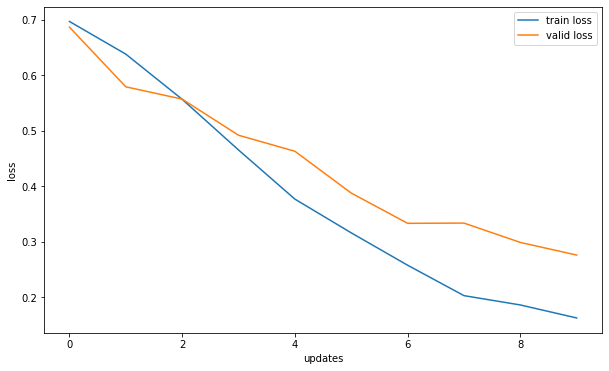

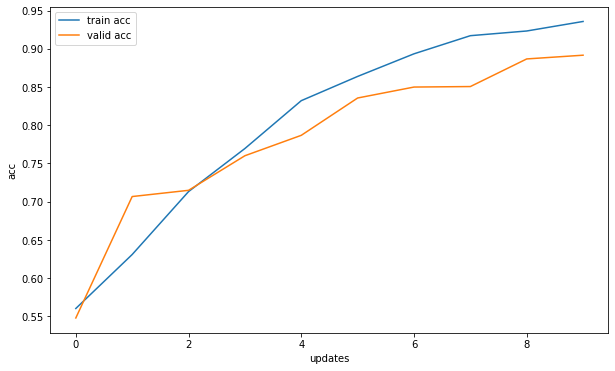

In [12]:
plot_performance(train_losses, valid_losses, "loss")
plot_performance(train_accs, valid_accs, "acc")

## 4. Evaluation on test set

In [13]:
model.load_state_dict(torch.load(model_saved_name))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.294 | Test Acc: 87.83%


## Final Verdict



Hmm....slightly better than the self attention only by 2%, showing the benefits of multiheads.